In [2]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
import numpy as np
import random
import matplotlib.pyplot as plt
import os
import glob
from tqdm import tqdm

try:
    os.chdir(os.path.join(os.getcwd(), '../../catchgame/'))
except:
    print("already in directory")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"{device} is available")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
already in directory
cuda is available


In [79]:

run_dir = "./runs"
runs = glob.glob(run_dir + "/*")
runs.sort()
print(f"Found {len(runs)} runs")
print(runs)

# Each folder contains a log.csv, concacatenate all of them into one dataframe with the respective run timestamp
import pandas as pd
dfs = []
for run in runs:
    df = pd.read_csv(run + "/log.csv").dropna()
    # runfile name has format run-timestamp
    timestamp = run.split("/")[-1]
    timestamp = timestamp.split("-")[1:]
    timestamp = "-".join(timestamp)
    df["timestamp"] = timestamp
    df["timestamp"] = pd.to_datetime(df["timestamp"], format="%Y-%m-%d-%H-%M-%S")

    dfs.append(df)

df = pd.concat(dfs)
df = df.sort_values(by=["timestamp", "episode"], ascending=[False, True])
df = df.reset_index(drop=True)
df.head(50)

Found 12 runs
['./runs\\run-2023-05-14-20-22-47', './runs\\run-2023-05-15-09-30-11', './runs\\run-2023-05-15-09-44-25', './runs\\run-2023-05-15-10-02-49', './runs\\run-2023-05-15-10-12-28', './runs\\run-2023-05-15-10-23-21', './runs\\run-2023-05-15-10-31-45', './runs\\run-2023-05-15-10-43-24', './runs\\run-2023-05-15-10-58-17', './runs\\run-2023-05-15-11-09-32', './runs\\run-2023-05-15-11-19-07', './runs\\run-2023-05-15-11-23-00']


,episode,epsilon,reward,mean_reward,timestamp
0,0,1.000000,NaN,0.0,2023-05-15 11:23:00
1,10,0.629166,NaN,0.4,2023-05-15 11:23:00
2,20,0.629166,NaN,0.4,2023-05-15 11:23:00
3,30,0.812729,NaN,0.2,2023-05-15 11:23:00
4,40,0.812729,NaN,0.2,2023-05-15 11:23:00
5,50,0.812729,NaN,0.2,2023-05-15 11:23:00
6,60,0.629166,NaN,0.4,2023-05-15 11:23:00
7,70,0.720489,NaN,0.3,2023-05-15 11:23:00
8,80,0.449238,NaN,0.6,2023-05-15 11:23:00
9,90,0.812729,NaN,0.2,2023-05-15 11:23:00


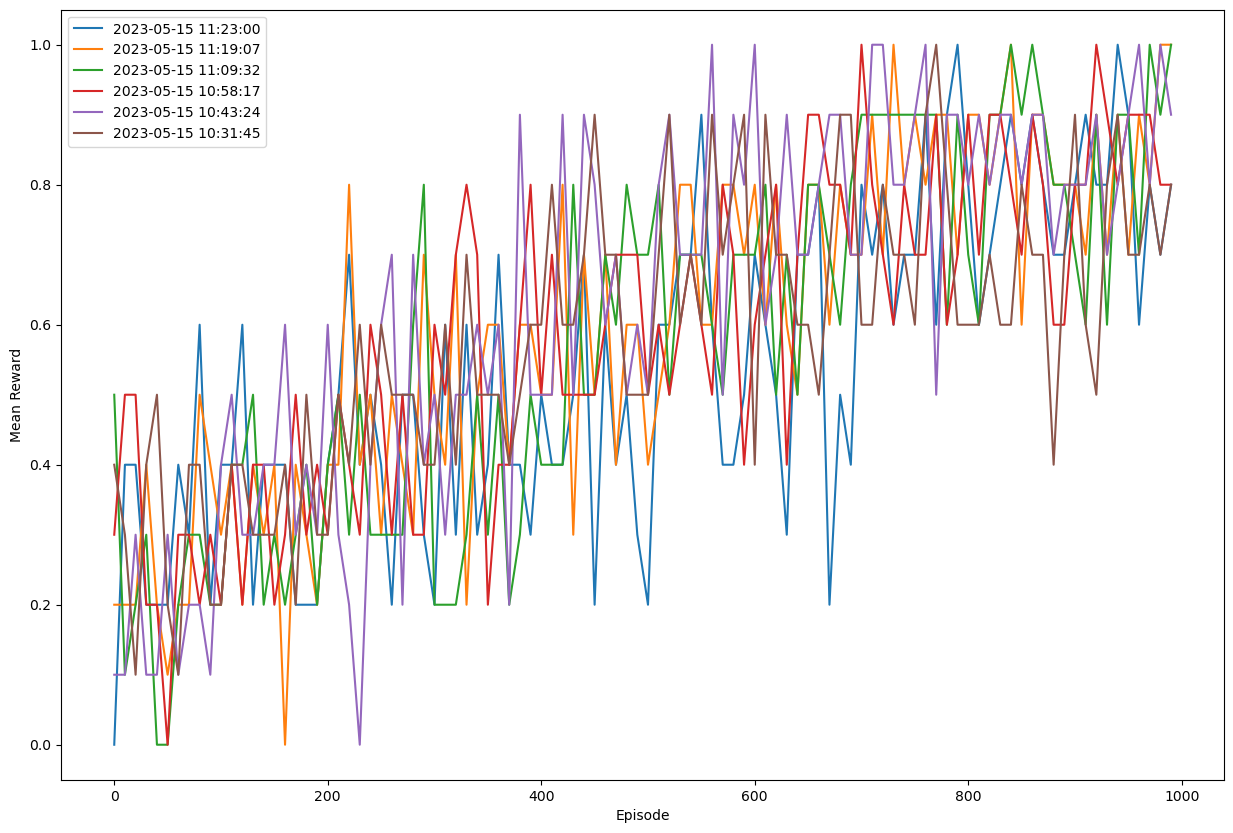

In [80]:
# plot all runs by timestamp and their respective reward
experiments = df.groupby("timestamp")
experiments = reversed(list(experiments))
print(experiments)

topk = 10
fig, ax = plt.subplots(figsize=(15, 10))
for experiment, group in experiments:
    if topk > 0:
        ax.plot(group["episode"], group["mean_reward"], label=experiment)
        topk -= 1
    else:
        break

ax.set_xlabel("Episode")
ax.set_ylabel("Mean Reward")
ax.legend()
plt.show()

In [83]:
# save the mean_reward of the top 5 experiments
# For the naming of these files, please use the following template:

# group_[number_of_the_group]_catch_rewards_[number_of_the_log].npy

# Which in the case of group 1 translates to:

# group_01_catch_rewards_1.npy

# our group is 60 
experiments = df.groupby("timestamp")
experiments = reversed(list(experiments))

i = 0

for (experiment, group) in experiments:
    print(experiment)
    if i < 5:
        if not os.path.exists("data"):
            os.makedirs("data")
        np.save(f"data/group_60_catch_rewards_{i+1}.npy", group["mean_reward"].to_numpy())
    else:
        break
    i += 1


2023-05-15 11:23:00
2023-05-15 11:19:07
2023-05-15 11:09:32
2023-05-15 10:58:17
2023-05-15 10:43:24
2023-05-15 10:31:45
